# GAN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
from torchvision import datasets 
import torchvision.transforms as transforms

import numpy as np
import random
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [3]:
train_data = datasets.MNIST(root='data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

test_data = datasets.MNIST(root='data/',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

In [4]:
batch_size = 100 # 한번에 할 연산량

train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=False)

## Generator

In [7]:
# generator: noise를 입력받아 이미지를 생성합니다.
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.nz = params['nz'] # 입력 노이즈 벡터 수, 100
        self.img_size = params['img_size'] # 이미지 크기, 1x28x28

        self.model = nn.Sequential(
            *self._fc_layer(self.nz, 128, normalize=False),
            *self._fc_layer(128,256),
            *self._fc_layer(256,512),
            *self._fc_layer(512,1024),
            nn.Linear(1024,int(np.prod(self.img_size))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_size)
        return img

    # fc layer
    def _fc_layer(self, in_channels, out_channels, normalize=True):
        layers = []
        layers.append(nn.Linear(in_channels, out_channels)) # fc layer
        if normalize:
            layers.append(nn.BatchNorm1d(out_channels, 0.8)) # BN
        layers.append(nn.LeakyReLU(0.2)) # LeakyReLU
        return layers

# check
params = {'nz':100,
          'img_size':(1,28,28)}
x = torch.randn(16,100).cuda() # random noise
model_gen = Generator(params).cuda()
output = model_gen(x) # noise를 입력받아 이미지 생성
print(output.shape)

torch.Size([16, 1, 28, 28])


## discriminator

In [8]:
# discriminator: 진짜 이미지와 가짜 이미지를 분류합니다.
class Discriminator(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.img_size = params['img_size'] # 이미지 크기, 1x28x28

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.model(x)
        return x

# check
x = torch.randn(16,1,28,28).cuda()
model_dis = Discriminator(params).cuda()
output = model_dis(x)
print(output.shape)

torch.Size([16, 1])


In [9]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights)
model_dis.apply(initialize_weights)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

## Train

In [10]:
# 손실 함수
loss_func = nn.BCELoss()
lr = 2e-4
beta1 = 0.5

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,0.999))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,0.999))

In [11]:
real_label = 1.
fake_label = 0.
nz = params['nz']
num_epochs = 100

loss_history={'gen':[],
              'dis':[]}

In [ ]:
batch_count = 0
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_loader:
        ba_si = xb.size(0)

        xb = xb.cuda()
        yb_real = torch.Tensor(ba_si,1).fill_(1.0).cuda()
        yb_fake = torch.Tensor(ba_si,1).fill_(0.0).cuda()

        # Generator
        model_gen.zero_grad()
        noise = torch.randn(ba_si,nz).cuda() # 노이즈 생성
        out_gen = model_gen(noise) # 가짜 이미지 생성
        out_dis = model_dis(out_gen) # 가짜 이미지 판별

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()

        # Discriminator
        model_dis.zero_grad()

        out_real = model_dis(xb) # 진짜 이미지 판별
        out_fake = model_dis(out_gen.detach()) # 가짜 이미지 판별
        loss_real = loss_func(out_real, yb_real)
        loss_fake = loss_func(out_fake, yb_fake)
        loss_dis = (loss_real + loss_fake) / 2

        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f' %(epoch, loss_gen.item(), loss_dis.item()))

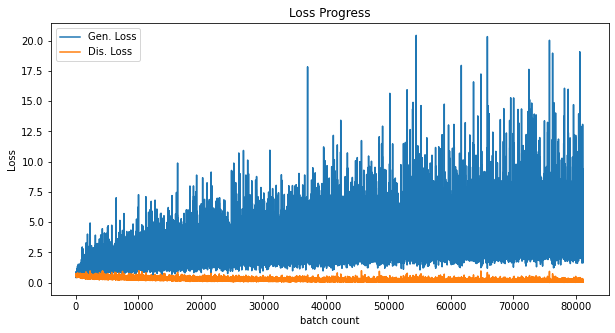

In [43]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
# 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [45]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evaluation mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100).cuda()
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


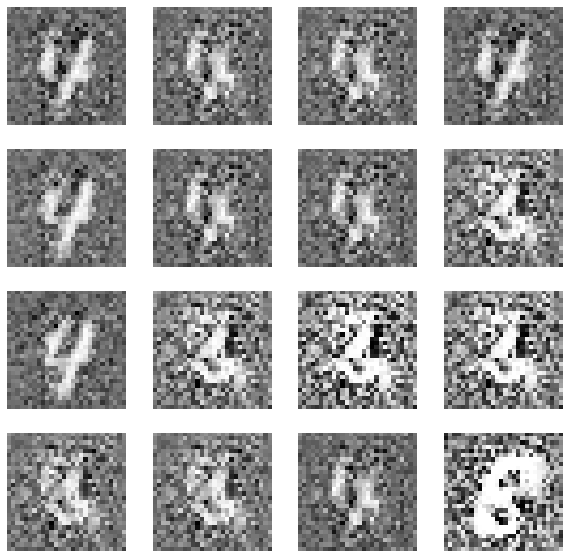

In [51]:
# 가짜 이미지 시각화
from torchvision.transforms.functional import to_pil_image
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5),cmap='gray')
    plt.axis('off')